In [1]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [16]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from src.hillshpaeDataModule import MySimCLRTrainDataTransform
from simCLR import *
from src import *

In [3]:
# Wind data load

with open('../../Share_Data/windspeed/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)

station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

In [4]:
# load config
config_path = 'configs/simclr_rgb.yaml'
checkpoint_path = '../../Share_Data/logs/SimCLR_CART/last.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
untrained_model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)
model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [6]:
# load img data
IMG_PATH = '../../Share_Data/satellite/jpg_cart_d10/_jpg_cart_d10/{}.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_parmas']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = (np.array(img_list)/255.)*2-1
tensor_img = torch.Tensor(img_list).permute(0,3,1,2)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_dataset)

In [7]:
model_latent = model.forward(tensor_img)
untrained_latent = untrained_model.forward(tensor_img)

model_projection = model.Projection(model_latent)
untrained_model_projection = untrained_model.Projection(untrained_latent)

print('size of latent : {}'.format(model_latent.size()))
print('size of projection : {}'.format(model_projection.size()))

size of latent : torch.Size([349, 512, 4, 4])
size of projection : torch.Size([349, 32])


# Analysis

In [8]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

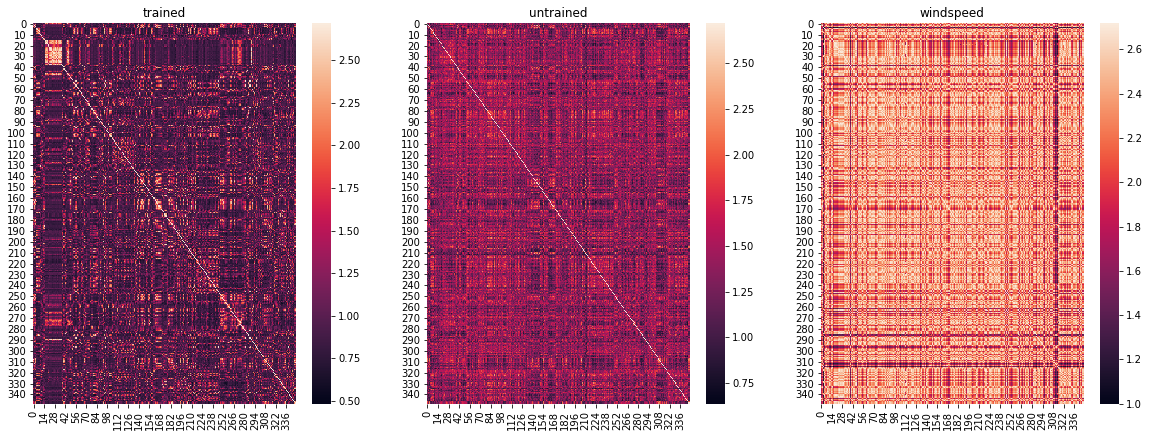

In [9]:
model_n = model_projection.norm(dim=1)[:,None]
model_n = torch.max(model_n, 1e-8*torch.ones_like(model_n))

un_model_n = untrained_model_projection.norm(dim=1)[:, None]
un_model_n = torch.max(un_model_n, 1e-8*torch.ones_like(un_model_n))

cov = torch.mm(model_projection/model_n, (model_projection/model_n).t().contiguous())
sim = torch.exp(cov)
untrained_cov = torch.mm(untrained_model_projection/un_model_n, (untrained_model_projection/un_model_n).t().contiguous())
untrained_sim = torch.exp(untrained_cov)

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(sim.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_sim.detach().numpy())

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff)
plt.show()

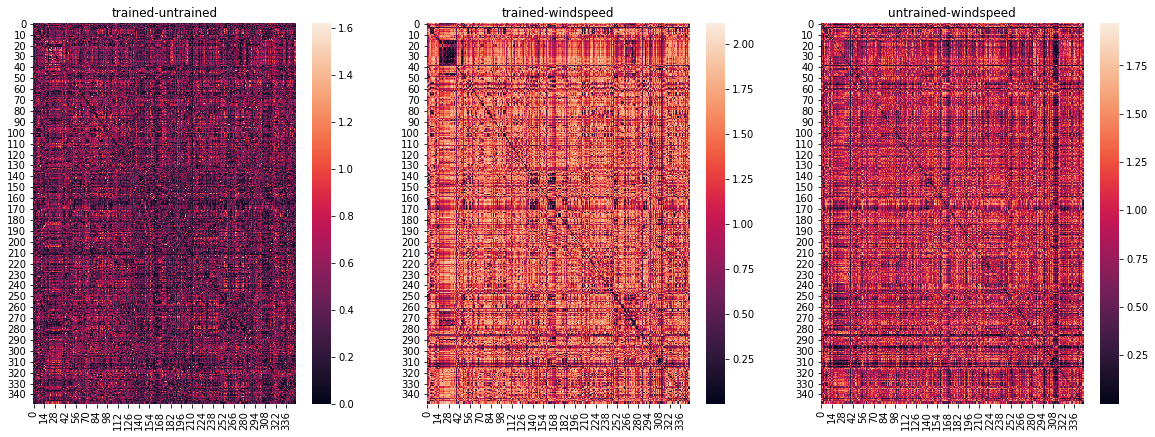

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained-untrained')
sns.heatmap(abs(sim.detach().numpy()-untrained_sim.detach().numpy()))

plt.subplot(1,3,2)
plt.title('trained-windspeed')
sns.heatmap(abs(sim.detach().numpy()-windspeed_diff))

plt.subplot(1,3,3)
plt.title('untrained-windspeed')
sns.heatmap(abs(untrained_sim.detach().numpy()-windspeed_diff))
plt.show()

---

# Content

* [latent_vector의 Similarity로 KNN하여 풍속 예측](#Experiment_1)
* [latent_vector의 Similarity로 KNN하여 풍속 예측+CART로 다시한것](#Experiment_2)


* [Report 1](#Report_1) *66번 인덱스*
* [Report 2](#Report_2) *104번 인덱스*
* [Report 3](#Report_3) *345번 인덱스*
* [Report 4](#Report_4) *4번 인덱스*
* [Report 5](#Report_5) *309번 인덱스*
* [Report 6](#Report_6) *39번 인덱스*

---

# Experiment_2
* 한번 latent_vector의 similarty를 기준으로 구해볼까...?
* windspeed의 기록을 CART가 분류한 값을 이용해서

[go to content](#Content)

In [17]:
import geopy.distance as gedistc

In [18]:
with open('../../Share_Data/windspeed/cart_change_windspeed.pickle', 'rb') as f:
    cart_windspeed = pickle.load(f)

In [22]:
num_K = 15
cov_np = sim.detach().numpy()
similar_list = []
result = []

wind_select_f = lambda x : list(cart_windspeed.values())[x]
code_select_f = lambda x : list(windspeed_dataset)[x]

# 가중치 없이 그냥 평균
for i_index in range(len(station_list)):
    select_list = cov_np[i_index].argsort()[-1-num_K : -1]
    select_wind = list(map(wind_select_f, select_list))
    select_code = list(map(code_select_f, select_list))
    select_dic = dict(zip(select_code, select_wind))
    similar_list.append(select_dic)
    
    result.append(np.mean(select_wind))

In [23]:
# distance weight sum

weight_result = []

for i_index, (to_code, to_dic) in enumerate(windspeed_dataset.items()):
    to_place = to_dic[:2]
    distance_list = []
    for j_index in similar_list[i_index]:
        from_place = windspeed_dataset[j_index][:2]
        distance_list.append(1/gedistc.distance(to_place, from_place).km) 
    weight_windspeed = sum(np.array(list(similar_list[i_index].values())) * np.array(distance_list))
    weight_result.append(weight_windspeed/sum(distance_list))

-0.4004882270323734
4.5109176460267335


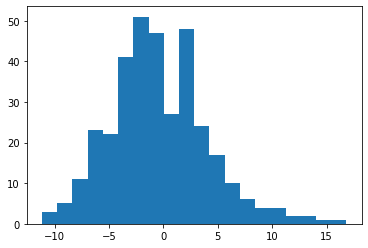

3.560876833268908
2.798021623847051


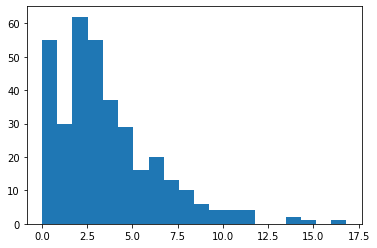

In [24]:
# --- k = 15
# --- Not distance Weight

plt.hist(windspeed_list-result, bins=20)
print(np.mean(windspeed_list-result))
print(np.std(windspeed_list-result))
plt.show()

plt.hist(np.abs(windspeed_list-result), bins=20)
print(np.mean(np.abs(windspeed_list-result)))
print(np.std(np.abs(windspeed_list-result)))
plt.show()

-0.2546269221054997
4.690655632427004


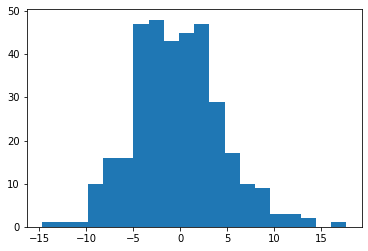

3.713540767895529
2.876925459002714


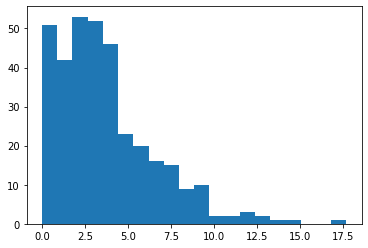

In [25]:
# --- k = 15
# --- apply distance Weight

plt.hist(windspeed_list-weight_result, bins=20)
print(np.mean(windspeed_list-weight_result))
print(np.std(windspeed_list-weight_result))
plt.show()

plt.hist(np.abs(windspeed_list-weight_result), bins=20)
print(np.mean(np.abs(windspeed_list-weight_result)))
print(np.std(np.abs(windspeed_list-weight_result)))
plt.show()

## Conclusion

* 이게더 좋긴함

---
# Experiment_1
* 한번 latent_vector의 similarty를 기준으로 구해볼까...?

[go to content](#Content)

In [11]:
import geopy.distance as gedistc

In [12]:
num_K = 15
cov_np = sim.detach().numpy()
similar_list = []
result = []

wind_select_f = lambda x : windspeed_list[x]
code_select_f = lambda x : list(windspeed_dataset)[x]

# 가중치 없이 그냥 평균
for i_index in range(len(station_list)):
    select_list = cov_np[i_index].argsort()[-1-num_K : -1]
    select_wind = list(map(wind_select_f, select_list))
    select_code = list(map(code_select_f, select_list))
    select_dic = dict(zip(select_code, select_wind))
    similar_list.append(select_dic)
    
    result.append(np.mean(select_wind))

In [13]:
# distance weight sum

weight_result = []

for i_index, (to_code, to_dic) in enumerate(windspeed_dataset.items()):
    to_place = to_dic[:2]
    distance_list = []
    for j_index in similar_list[i_index]:
        from_place = windspeed_dataset[j_index][:2]
        distance_list.append(1/gedistc.distance(to_place, from_place).km) 
    weight_windspeed = sum(np.array(list(similar_list[i_index].values())) * np.array(distance_list))
    weight_result.append(weight_windspeed/sum(distance_list))

-0.02535147220982219
4.34802367399403


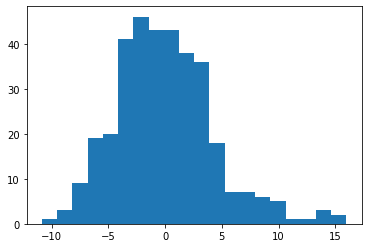

3.358898388781756
2.761114662703284


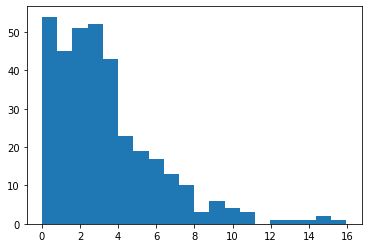

In [14]:
# --- k = 15
# --- Not distance Weight

plt.hist(windspeed_list-result, bins=20)
print(np.mean(windspeed_list-result))
print(np.std(windspeed_list-result))
plt.show()

plt.hist(np.abs(windspeed_list-result), bins=20)
print(np.mean(np.abs(windspeed_list-result)))
print(np.std(np.abs(windspeed_list-result)))
plt.show()

0.03364910018808647
4.459295719073651


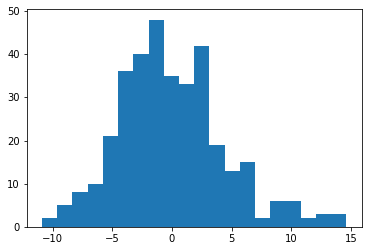

3.4866922132411644
2.780184882739903


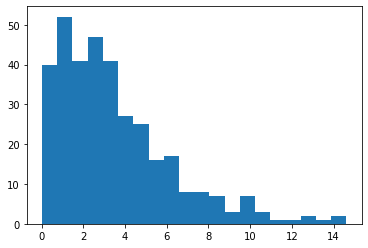

In [15]:
# --- k = 15
# --- apply distance Weight

plt.hist(windspeed_list-weight_result, bins=20)
print(np.mean(windspeed_list-weight_result))
print(np.std(windspeed_list-weight_result))
plt.show()

plt.hist(np.abs(windspeed_list-weight_result), bins=20)
print(np.mean(np.abs(windspeed_list-weight_result)))
print(np.std(np.abs(windspeed_list-weight_result)))
plt.show()

---
# Report_3
* 294(인덱스 347)
* 162(309)
* 909(251)
* 918(259)
* 921(262)

[go to content](#Content)

In [11]:
a_index = 347
b_index = 309
c_index = 251
d_index = 259
e_index = 262

In [15]:
# z list
select_value = []
select_value.append(model_projection[a_index].detach().numpy())
select_value.append(model_projection[b_index].detach().numpy())
select_value.append(model_projection[c_index].detach().numpy())
select_value.append(model_projection[d_index].detach().numpy())
select_value.append(model_projection[e_index].detach().numpy())

# origin
img_a = (img_list[a_index]+1)/2
img_b = (img_list[b_index]+1)/2
img_c = (img_list[c_index]+1)/2
img_d = (img_list[d_index]+1)/2
img_e = (img_list[e_index]+1)/2

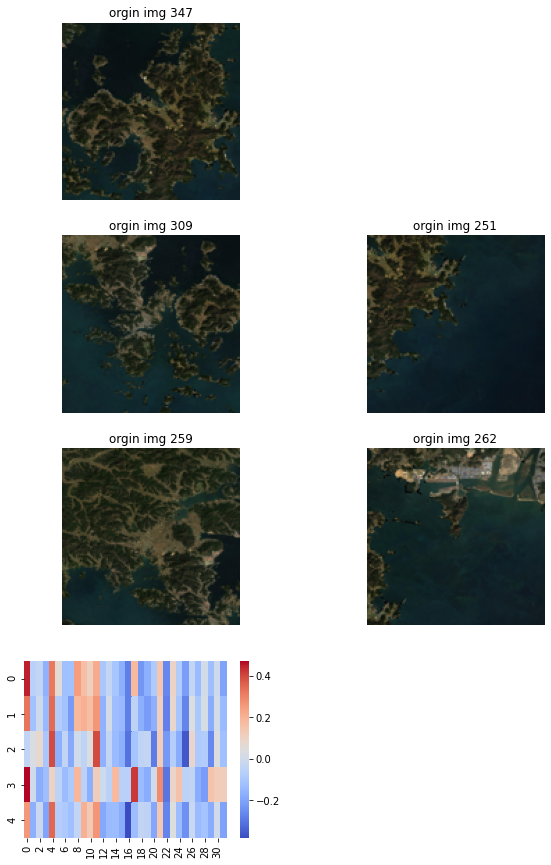

In [16]:
plt.figure(figsize=(10,15))

plt.subplot(4,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(4,2,3)
plt.imshow(img_b)
plt.title('orgin img {}'.format(b_index))
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(img_c)
plt.title('orgin img {}'.format(c_index))
plt.axis('off')

plt.subplot(4,2,5)
plt.imshow(img_d)
plt.title('orgin img {}'.format(d_index))
plt.axis('off')

plt.subplot(4,2,6)
plt.imshow(img_e)
plt.title('orgin img {}'.format(e_index))
plt.axis('off')

plt.subplot(4,2,7)
sns.heatmap(select_value, cmap='coolwarm')
plt.show()

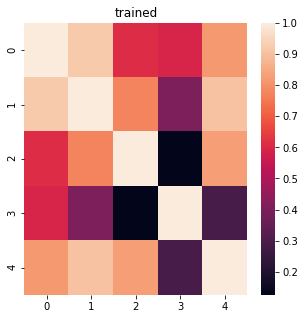

In [17]:
v_tensor = torch.tensor(select_value)

z_n = v_tensor.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

cov = torch.mm(v_tensor/z_n, (v_tensor/z_n).t().contiguous())

plt.figure(figsize=(5,5))
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.show()

In [19]:
(cov.detach().numpy()[a_index]).argsort()[-2]

309

In [20]:
cov.detach().numpy()[a_index, 309]

0.92294574

In [21]:
list(windspeed_dataset)[309]

'162'

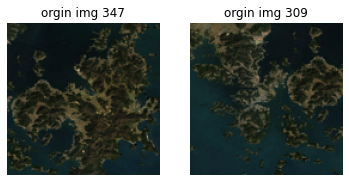

In [23]:
img_similar = (img_list[309]+1)/2

plt.subplot(1,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_similar)
plt.title('orgin img {}'.format('309'))
plt.axis('off')

plt.show()

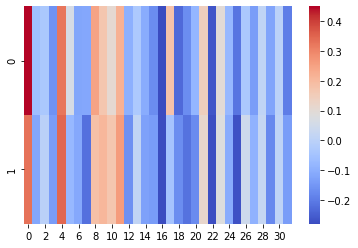

In [25]:
a_z = model_projection[347].detach().numpy().reshape(1,-1)
b_z = model_projection[309].detach().numpy().reshape(1,-1)
total_z = np.concatenate([a_z, b_z], axis=0)

sns.heatmap(total_z, cmap='coolwarm')
plt.show()

* 오... 일단 similar는 VAE에 비해 상다잏 좋은데?

### Report_1
* 66번 인덱스와 39번 인덱스 차이 비교

[go to content](#Content)

In [23]:
select_value = []
select_value.append(model_projection[66].detach().numpy())
select_value.append(model_projection[39].detach().numpy())

<AxesSubplot:>

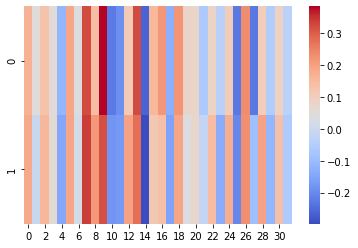

In [26]:
sns.heatmap(select_value, cmap='coolwarm')